# Práctica Final - Detección de comentarios de odio en Twitter

## Índice de la práctica

- [Partición de datos en conjuntos](#Partición-de-datos-en-conjuntos)
- [Aprendizaje sin preprocesar](#Aprendizaje-sin-preprocesar)
- [Preprocesamiento base](#Preprocesamiento-base)
- [Eliminación de palabras que no existen](#Eliminación-de-palabras-que-no-existen)
- [Reducción a forma raíz](#Reducción-a-forma-raíz)
- [Detección de Outliers](#Detección-de-Outliers)
- [Empleo de Pipelines](#Empleo-de-Pipelines)
- [Reducción de Instancias](#Reducción-de-Instancias)

El estudio que vamos a realizar es sobre un dataset de tweets que han sido clasificados como tweet de odio o no. La motivación detrás de la elección de este conjunto de datos, viene dada por el auge del uso de las redes sociales en nuestro día a día y como el odio puede tomar muchísimas formas en la red, y además como es un tema bastante recurrente y presente en nuestro día a día, pues resulta interesante adentrarse un poco en el tema y realizar una exploración del mismo.

A continuación, comenzaremos el estudio, realizando la implementación de las librerías necesarias para realizar un buen preprocesamiento de los datos.

In [1]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Álvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, neighbors, tree, preprocessing
from scipy import stats
import random
from sklearn.utils import shuffle

import nltk
nltk.download('words')
nltk.download('wordnet')       
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from shutil import copyfile

import warnings
warnings.filterwarnings("ignore") 

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Álvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Álvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Álvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Álvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Partición de datos en conjuntos
Realizamos una partición de los tweets en conjuntos de entrenamiento y test.

In [3]:
np.random.seed(12)

# Importamos datos con TODAS sus variables y obtenemos ejemplos con valores nulos.
datos = pd.read_csv("HateSpeechDataset.csv")
for i in datos.columns:
    print(i,":",datos[str(i)].isnull().sum()/datos.shape[0])
    
# Eliminamos esas entradas con alguna variable con valor nulo.
datos.dropna(axis = 0,inplace = True)
for i in datos.columns:
    print(i,":",datos[str(i)].isnull().sum()/datos.shape[0])

Unnamed: 0 : 0.0
id : 0.0
text : 0.0
label : 0.0
type : 0.0
model_wrong : 0.35758068089505946
db.model_preds : 0.35758068089505946
status : 0.0
round : 0.0
split : 0.0
annotator : 0.0
Unnamed: 0 : 0.0
id : 0.0
text : 0.0
label : 0.0
type : 0.0
model_wrong : 0.0
db.model_preds : 0.0
status : 0.0
round : 0.0
split : 0.0
annotator : 0.0


Podemos observar la cantidad de variables que tenemos y sus nombres.  
        · Unnamed - Índice del tweet. (Se renombrará al Index)  
        · id - Identificador del tweet. (No se tendrá en cuenta)  
    · text - Contenido del tweet. (Sí se tendrá en cuenta y será imprescindible)  
    · label - Clasificación del tweet como hate/nothate. (Se tendrá en cuenta también)  
    · type - Tipo de odio que contiene, hacia quién va dirigido. (No se tendrá en cuenta, se podría realizar otro estudio con ese)  
    · model_wrong - Si el modelo generado por el creador del dataset acertó o no. (No se tendrá en cuenta)  
    El resto de variables que quedan, tampoco se tendrán en cuenta, no son importantes ni significativas del dataset.

A continuación procederemos a la partición de los datos en conjuntos de entrenamiento y test para la realización de la 
    minería y posterior aprendizaje del modelo y clasificación.    
      
La división en conjuntos, será realizada en train/test con una división del 80%/20% de forma aleatoria.  
  
No obstante, antes de continuar implementaremos una función que permita la representación del dataset a través de una reducción de componentes, como un PCA, pero adaptado a este tipo de instancias, que sería el LSA (Analísis Semántico Latente).

In [4]:
# Función para representación del dataset obtenido en formato de plot.
import matplotlib
import matplotlib.patches as mpatches
from sklearn.decomposition import TruncatedSVD
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Hate')
            blue_patch = mpatches.Patch(color='blue', label='Not Hate')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 10})

# Aprendizaje sin preprocesar

En primer lugar vamos a realizar el aprendizaje del modelo con los conjuntos de datos obtenidos previamente y sin realizar
ningún tipo de preprocesamiento sobre los datos y ver qué tal actúa así y sentar las bases del posterior aprendizaje.

In [5]:
np.random.seed(12)

# La partición será del 80% - 20%
longitud = int(datos.shape[0])
division = int(longitud*0.8)

# Transformamos las salidas en 0 y 1.
datos = datos[["text","label"]]
label = {'hate':0 , 'nothate':1}
datos['label'] = datos['label'].map(label)

X_train = datos.iloc[:division,0]
X_test = datos.iloc[division:,0]
y_train = datos.iloc[:division,1]
y_test = datos.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [6]:
np.random.seed(12)

# Obtenemos las distintas palabras que hay en los tweets.
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
palabrasAprendidas = vectorizer.get_feature_names()

tdidf = TfidfTransformer()

X_train_tfidf = tdidf.fit_transform(X_train_counts)

clf_NB = MultinomialNB().fit(X_train_tfidf, y_train)
prediccionNB_train = clf_NB.predict(X_train_tfidf)
accuracyTrain = metrics.accuracy_score(prediccionNB_train, y_train) * 100
specificityTrain = metrics.recall_score(prediccionNB_train, y_train, pos_label=0) * 100

X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tdidf.transform(X_test_counts)
prediccionNB_test = clf_NB.predict(X_test_tfidf)
accuracyTest = metrics.accuracy_score(prediccionNB_test, y_test) * 100
specificityTest = metrics.recall_score(prediccionNB_test, y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accuracyTrain)
print("Precisión en Test : %0.2f" % accuracyTest)

print("Specificity en Train: %0.2f" % specificityTrain)
print("Specificity en Test: %0.2f" % specificityTest)

print(X_train_tfidf.shape)

Precisión en Train : 90.74
Precisión en Test : 72.43
Specificity en Train: 88.30
Specificity en Test: 70.50
(20877, 15520)


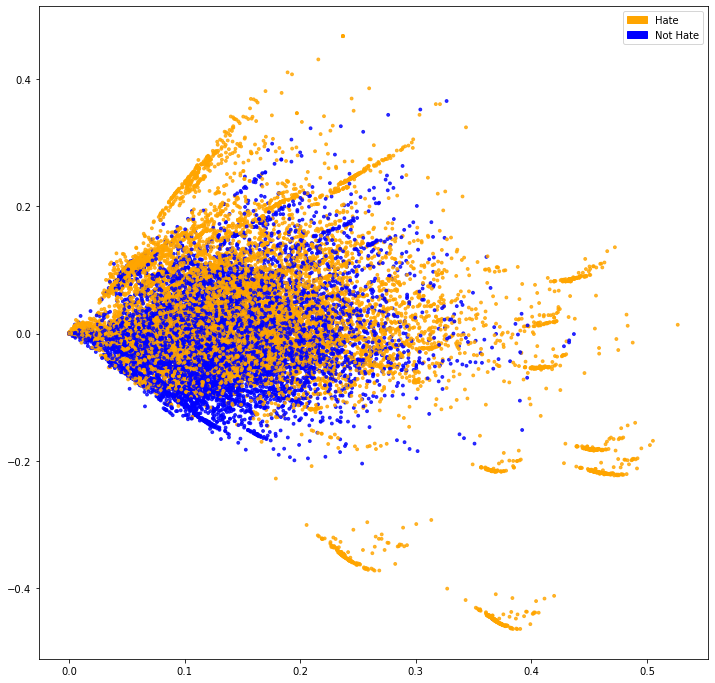

In [7]:
fig = plt.figure(figsize=(12, 12))    
plot_LSA(X_train_tfidf, y_train)
plt.show()

Podemos observar en la gráfica que los datos de nuestro dataset no van a ser fáciles de clasificar sin aplicar algún tipo de preprocesamiento, ya que están muy mezclados. No obstante, sí que podemos observar una cantidad mayor de comentarios de la clase negativa (hate) en la parte superior y una cantidad mas abundante de ejemplos de la positiva (not hate) según vamos bajando en el eje y.

Por otro lado, por debajo del grupo de puntos principal, podemos observar que hay datos pertenecientes a la clase negativa que forman clusters bastante separados entre si. Tiene pinta de ser outliers.

# Preprocesamiento de los datos:

A continuación, comenzaremos con el preprocesado de datos y vamos a ir probando diferentes métodos de preprocesamiento de texto y mirando el specificity de cada uno respecto a un clasificador base para poder elegir los datos mas apropiados con los que entrenar los modelos.

## Preprocesamiento base

Para comenzar empezamos por eliminar los elementos numéricos, stopwords, signos de puntuación o palabras cuyas apariciones en el dataset sean menores a un umbral.

In [8]:
def clean_txt(txt):
        # Eliminamos elementos numéricos.
        txt =''.join(i for i in txt if not i.isdigit())
        ## Eliminamos cualquier tipo de puntuación que haya.
        txt = re.sub(r'[^\w\s]', ' ', txt) 
        ## Eliminamos stopwords previamente importadas
        txt = ' '.join([i for i in txt.split() if not i in STOPWORDS])
        ## Eliminamos palabras de tamaño menor que un valor numérico.
        txt =' '.join([i for i in txt.split() if len(i)>2])
        ## Realizamos una lematización
        txt=lemmatizer.lemmatize(txt)
        return txt

In [9]:
# Realizamos la limpieza de los datos.
datos['Clean Text'] = datos['text'].apply(clean_txt)
datos_sinProc = datos[['Clean Text','label']].copy()

X_train = datos_sinProc.iloc[:division,0]
X_test = datos_sinProc.iloc[division:,0]
y_train = datos_sinProc.iloc[:division,1]
y_test = datos_sinProc.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [10]:
np.random.seed(12)

# Obtenemos las distintas palabras que hay en los tweets.
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
palabrasAprendidas = vectorizer.get_feature_names()

tdidf = TfidfTransformer()

X_train_tfidf = tdidf.fit_transform(X_train_counts)

clf_NB = MultinomialNB().fit(X_train_tfidf, y_train)
prediccionNB_train = clf_NB.predict(X_train_tfidf)
accuracyTrain = metrics.accuracy_score(prediccionNB_train, y_train) * 100
specificityTrain = metrics.recall_score(prediccionNB_train, y_train, pos_label=0) * 100

X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tdidf.transform(X_test_counts)
prediccionNB_test = clf_NB.predict(X_test_tfidf)
accuracyTest = metrics.accuracy_score(prediccionNB_test, y_test) * 100
specificityTest = metrics.recall_score(prediccionNB_test, y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accuracyTrain)
print("Precisión en Test : %0.2f" % accuracyTest)

print("Specificity en Train: %0.2f" % specificityTrain)
print("Specificity en Test: %0.2f" % specificityTest)

print(X_train_tfidf.shape)

Precisión en Train : 91.51
Precisión en Test : 72.43
Specificity en Train: 89.97
Specificity en Test: 71.31
(20877, 15008)


### Distribución de los datos

Podemos mostrar los datos para observar que distribución siguen o la disposición de cada uno de ellos.

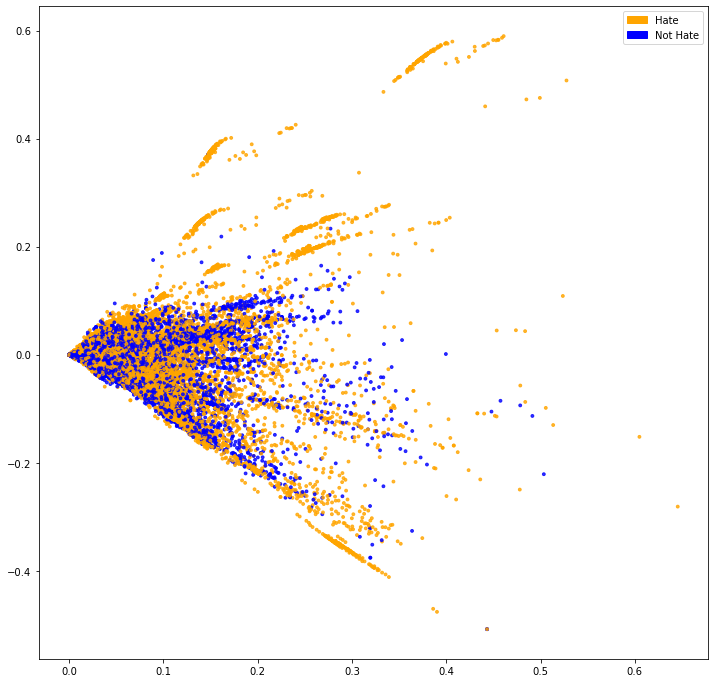

In [11]:
fig = plt.figure(figsize=(12, 12))    
plot_LSA(X_train_tfidf, y_train)
plt.show()

Analizando los resultados obtenidos, vemos que hemos conseguido reducir la cantidad de palabras totales y con ello la mayoría de los outliers que se encontraban por la parte inferior del gráfico. Sin embargo, la distribución de los datos sigue siendo difícil de clasificar. Veamos pues si conseguimos mejorarlo.

Además, como medida de rendimiento nos fijaremos principalmente en el Specificity (True negative rate), ya que nos interesa mas el asegurar que acertamos los ejemplos de la clase negativa (comentarios con discurso de odio) ya que el no detectar uno de estos puede causar un impacto mayor que el clasificar erroneamente un tweet inofensivo.

En este caso, hemos aumentado el specificity tanto en train como en test, vamos por buen camino.

## Eliminación de palabras que no existen

OBJETIVO : Eliminar de los tweets aquellas palabras que no existan o hayan sido mal escritas. La motivación detrás de esta implementación viene por quedarnos solo con aquello que al ojo humano puede ser clasificado. Existen varios inconvenientes de aplicar este método, puesto que insultos escritos de la forma "3rr0r, 4nim41" pasarán desapercibidos.

In [12]:
datos_del = datos[['Clean Text','label']].copy()

import nltk
words = set(nltk.corpus.words.words())

for i in range(len(datos)):
    word_list = nltk.wordpunct_tokenize(datos.iloc[i,0])
    lemmatized_output = ' '.join(w for w in word_list)
    datos_del.iloc[i,0] = lemmatized_output
    
print(datos_del.shape)

(26097, 2)


In [13]:
np.random.seed(12)

division = int(longitud*0.8)

X_train = datos_del.iloc[:division,0]
X_test = datos_del.iloc[division:,0]
y_train = datos_del.iloc[:division,1]
y_test = datos_del.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [14]:
# Obtenemos las distintas palabras que hay en los tweets.
vectorizer = CountVectorizer(stop_words = "english")
X_train_counts = vectorizer.fit_transform(X_train)
palabrasAprendidas = vectorizer.get_feature_names()

tdidf = TfidfTransformer()

X_train_tfidf = tdidf.fit_transform(X_train_counts)

clf_NB = MultinomialNB().fit(X_train_tfidf, y_train)
prediccionNB_train = clf_NB.predict(X_train_tfidf)
accuracyTrain = metrics.accuracy_score(prediccionNB_train, y_train) * 100
specificityTrain = metrics.recall_score(prediccionNB_train, y_train, pos_label=0) * 100

X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tdidf.transform(X_test_counts)
prediccionNB_test = clf_NB.predict(X_test_tfidf)
accuracyTest = metrics.accuracy_score(prediccionNB_test, y_test) * 100
specificityTest = metrics.recall_score(prediccionNB_test, y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accuracyTrain)
print("Precisión en Test : %0.2f" % accuracyTest)

print("Specificity en Train: %0.2f" % specificityTrain)
print("Specificity en Test: %0.2f" % specificityTest)

print(X_train_tfidf.shape)
print(y_train.shape)

Precisión en Train : 91.52
Precisión en Test : 72.95
Specificity en Train: 89.95
Specificity en Test: 71.67
(20877, 15226)
(20877,)


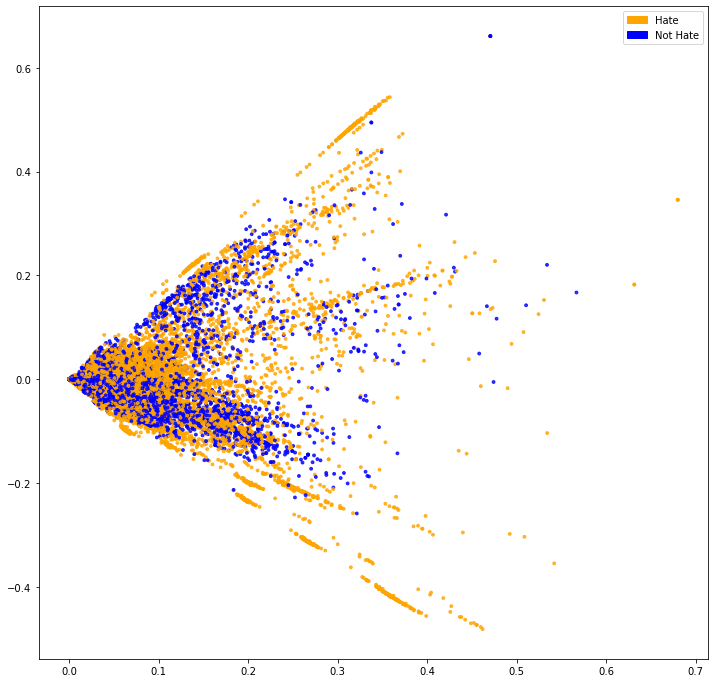

In [15]:
fig = plt.figure(figsize=(12, 12))    
plot_LSA(X_train_tfidf, y_train)
plt.show()

Como podemos observar en la gráfica, la separación de datos ha mejorado respecto al anterior, habiendo dos grupos principales de puntos azules (clase positiva). No obstante vamos a probar con otras técnicas.

También observamos que el Specificity ha bajado en train (aunque la bajada sea mínima) y ha aumentado en test (aunque también es una mejora muy pequeña).

# Reducción a forma raíz

OBJETIVO : Reducimos las palabras a través de las técnicas de stemming y lemmatization (no a la vez) con el fin de
    reducir los términos transformándolos a su forma básica y reducir de esta forma palabras pertenecientes a la misma familia.

### Lemmatización: 

##### Este método tarda un poco en ejecutar, unos 5-10 minutos

Para cada palabra buscamos su tipo de palabra para obtener el correcto POS tag (part of speech tag), para que al aplicar la lematización reduzca a la forma base correcta de la palabra, es decir, nos clasificará cada palabra en base a su familia gramatical.

In [16]:
lemmatizer = WordNetLemmatizer()
datos_lemm = datos[['Clean Text','label']].copy()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

for i in range(len(datos)):
    word_list = nltk.word_tokenize(datos.iloc[i,0])
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    datos_lemm.iloc[i,0] = lemmatized_output

In [17]:
np.random.seed(12)

division = int(longitud*0.8)

X_train = datos_lemm.iloc[:division,0]
X_test = datos_lemm.iloc[division:,0]
y_train = datos_lemm.iloc[:division,1]
y_test = datos_lemm.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [18]:
vectorizer = CountVectorizer(stop_words = "english")
X_train_counts = vectorizer.fit_transform(X_train)
palabrasAprendidas = vectorizer.get_feature_names()

tdidf = TfidfTransformer()

X_train_tfidf = tdidf.fit_transform(X_train_counts)

clf_NB = MultinomialNB().fit(X_train_tfidf, y_train)
prediccionNB_train = clf_NB.predict(X_train_tfidf)
accuracyTrain = metrics.accuracy_score(prediccionNB_train, y_train) * 100
specificityTrain = metrics.recall_score(prediccionNB_train, y_train, pos_label=0) * 100

X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tdidf.transform(X_test_counts)
prediccionNB_test = clf_NB.predict(X_test_tfidf)
accuracyTest = metrics.accuracy_score(prediccionNB_test, y_test) * 100
specificityTest = metrics.recall_score(prediccionNB_test, y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accuracyTrain)
print("Precisión en Test : %0.2f" % accuracyTest)

print("Specificity en Train: %0.2f" % specificityTrain)
print("Specificity en Test: %0.2f" % specificityTest)

print(X_train_tfidf.shape)

Precisión en Train : 90.41
Precisión en Test : 72.26
Specificity en Train: 88.75
Specificity en Test: 71.17
(20877, 12770)


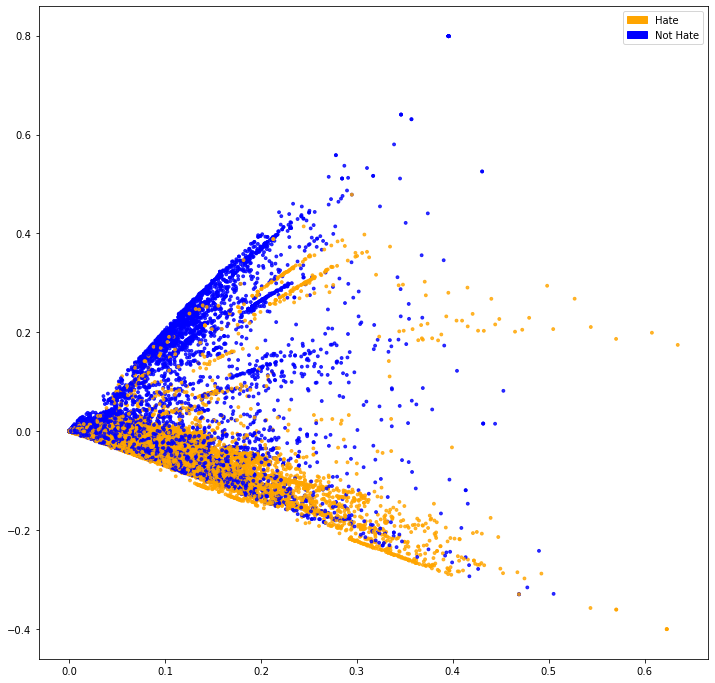

In [19]:
fig = plt.figure(figsize=(12, 12))    
plot_LSA(X_train_tfidf, y_train)
plt.show()

Como podemos observar en esta gráfica, hasta el momento es la distribución de datos que mejor nos ha separado los datos, creando dos 'alas' principales, la superior para la clase positiva y la inferior para la negativa.

Además, a pesar de que el specificity en train haya bajado, la bajada no ha sido tan significativa. En cuanto al specificity en test, observamos que apenas ha cambiado, por tanto tenemos ante nosotros un buen candidato para la clasificación del problema, teniendo como único inconveniente que las celdas tardan un poco mas en ejecutar.

### Stemming:

In [20]:
from nltk.stem import PorterStemmer

np.random.seed(12)

ps = PorterStemmer()

datos_stem = datos[['Clean Text','label']].copy()

for i in range(len(datos)):
    word_list = nltk.word_tokenize(datos.iloc[i,0])
    stem_output = ' '.join([ps.stem(w) for w in word_list])
    datos_stem.iloc[i,0] = stem_output

In [21]:
np.random.seed(12)

division = int(longitud*0.8)

X_train = datos_stem.iloc[:division,0]
X_test = datos_stem.iloc[division:,0]
y_train = datos_stem.iloc[:division,1]
y_test = datos_stem.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [22]:
vectorizer = CountVectorizer(stop_words = "english")
X_train_counts = vectorizer.fit_transform(X_train)
palabrasAprendidas = vectorizer.get_feature_names()

tdidf = TfidfTransformer()

X_train_tfidf = tdidf.fit_transform(X_train_counts)

clf_NB = MultinomialNB().fit(X_train_tfidf, y_train)
prediccionNB_train = clf_NB.predict(X_train_tfidf)
accuracyTrain = metrics.accuracy_score(prediccionNB_train, y_train) * 100
specificityTrain = metrics.recall_score(prediccionNB_train, y_train, pos_label=0) * 100

X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tdidf.transform(X_test_counts)
prediccionNB_test = clf_NB.predict(X_test_tfidf)
accuracyTest = metrics.accuracy_score(prediccionNB_test, y_test) * 100
specificityTest = metrics.recall_score(prediccionNB_test, y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accuracyTrain)
print("Precisión en Test : %0.2f" % accuracyTest)

print("Specificity en Train: %0.2f" % specificityTrain)
print("Specificity en Test: %0.2f" % specificityTest)

print(X_train_tfidf.shape)

Precisión en Train : 89.45
Precisión en Test : 72.03
Specificity en Train: 87.64
Specificity en Test: 70.99
(20877, 10633)


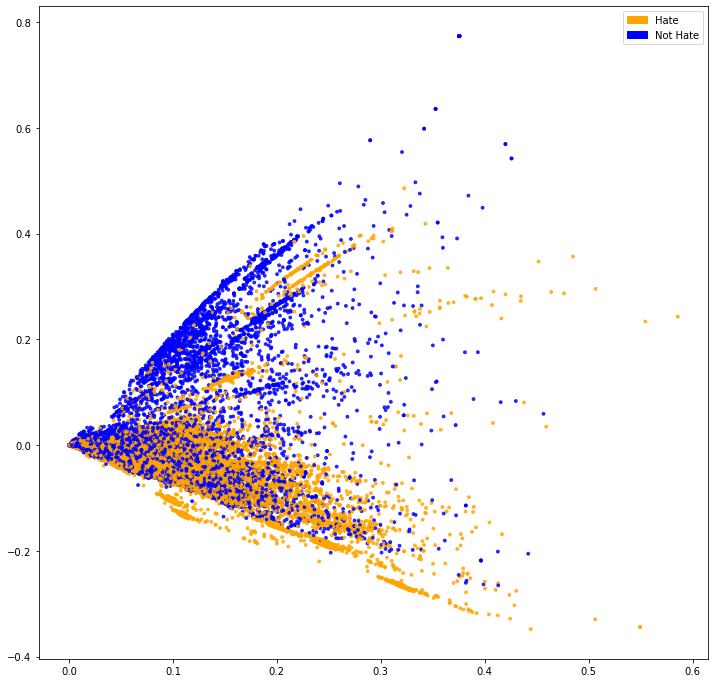

In [23]:
fig = plt.figure(figsize=(12, 12))    
plot_LSA(X_train_tfidf, y_train)
plt.show()

Similar a la lematización, el stemming también nos devuelve una distribución de los datos aceptable, sin embargo no consigue separar los ejemplos tan claramente. Esta diferencia puede ser ocasionada por la existencia de palabras irregulares en inglés, que pueden acabar generando 2 palabras diferentes para el mismo significado, por ejemplo "studies -> studi" y "studying -> study" tienen el mismo significado pero serían clasificadas como diferentes, cosa que con lemmatization no ocurre.

Además, observamos observamos que el specificity ha bajado tanto en train como en test.

# Detección de Outliers

OBJETIVO : Eliminar aquellas palabras que tengan una frecuencia de aparición muy elevada o muy baja con el fin de quedarnos
    con aquellas que representen mejor el corpus. No es como tal una detección de outliers, sino quedarnos con aquellas palabras que estén contenidas dentro de un rango específico.

In [24]:
def deteccionOutliers_MeanStd(df, k = 1.5):
    aux = df.copy()
    for i in df.columns:
        lista1 = df[i] < df[i].mean() - k*df[i].std()
        lista2 = df[i] > df[i].mean() + k*df[i].std()
        aux[i] = np.logical_or(lista1, lista2)
        print(df[i].mean() - k*df[i].std())
        print(df[i].mean() + k*df[i].std())
    return aux.any(axis=1)

dataset = datos[['Clean Text','label']].copy()

vectorizer = CountVectorizer(stop_words = "english")
vectorizer.fit_transform(dataset['Clean Text'])

# Obtenemos un dataframe con cada palabra y su frecuencia de aparición.
datosPanda = {'Word' : vectorizer.vocabulary_.keys(),
       'Conteo' : vectorizer.vocabulary_.values()}
dataset = pd.DataFrame(data = datosPanda, columns = ['Word','Conteo'])

# Nos quedamos con el conteo únicamente y aplicamos la detección de la media y desviación.
dataset_p =  {'Conteo' : vectorizer.vocabulary_.values()}
dataset_p = pd.DataFrame(data = dataset_p, columns=['Conteo'])

resultado = deteccionOutliers_MeanStd(dataset_p)
datos_sinOut = dataset[np.logical_not(resultado)]

# Nos quedaríamos con la siguiente cantidad de palabras.
print(np.logical_not(resultado).sum())

1123.1293972294316
15652.870602770568
14529


In [25]:
# Eliminamos de los tweets aquellas palabras que sean considerados outliers
words = list(datos_sinOut.Word)
datos_sinOut = datos[['Clean Text','label']].copy()

for i in range(len(datos)):
    word_list = nltk.word_tokenize(datos_sinOut.iloc[i,0])
    lemmatized_output = ' '.join(w for w in word_list \
                                 if w in words) 
    datos_sinOut.iloc[i,0] = lemmatized_output

In [26]:
np.random.seed(12)

division = int(longitud*0.8)

X_train = datos_sinOut.iloc[:division,0]
X_test = datos_sinOut.iloc[division:,0]
y_train = datos_sinOut.iloc[:division,1]
y_test = datos_sinOut.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [27]:
vectorizer = CountVectorizer(stop_words = "english")
X_train_counts = vectorizer.fit_transform(X_train)
palabrasAprendidas = vectorizer.get_feature_names()

tdidf = TfidfTransformer()

X_train_tfidf = tdidf.fit_transform(X_train_counts)

clf_NB = MultinomialNB().fit(X_train_tfidf, y_train)
prediccionNB_train = clf_NB.predict(X_train_tfidf)
accuracyTrain = metrics.accuracy_score(prediccionNB_train, y_train) * 100
specificityTrain = metrics.recall_score(prediccionNB_train, y_train, pos_label=0) * 100

X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tdidf.transform(X_test_counts)
prediccionNB_test = clf_NB.predict(X_test_tfidf)
accuracyTest = metrics.accuracy_score(prediccionNB_test, y_test) * 100
specificityTest = metrics.recall_score(prediccionNB_test, y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accuracyTrain)
print("Precisión en Test : %0.2f" % accuracyTest)

print("Specificity en Train: %0.2f" % specificityTrain)
print("Specificity en Test: %0.2f" % specificityTest)

print(X_train_tfidf.shape)

Precisión en Train : 89.55
Precisión en Test : 68.74
Specificity en Train: 88.26
Specificity en Test: 69.63
(20877, 11490)


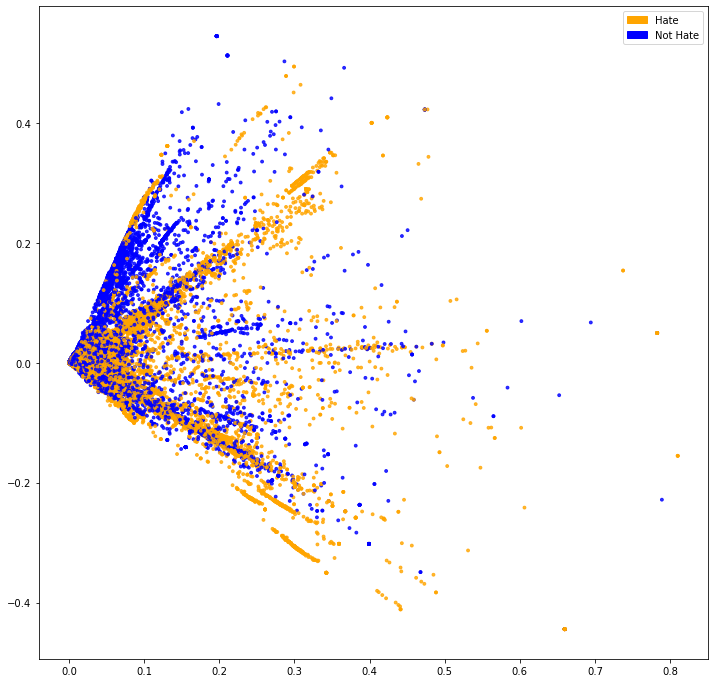

In [28]:
fig = plt.figure(figsize=(12, 12))    
plot_LSA(X_train_tfidf, y_train)
plt.show()

Podemos observar una ligera mejoría en la separación de los datos con respecto al dataset inicial, pero siendo realistas, esta técnica no es bastante fiable puesto que palabras importantes han podido ser eliminadas en este procesamiento ya que solo se tiene en cuenta su frecuencia de aparición y no su importancia dentro del contexto del tweet, pero esto implicaría técnicas más avanzadas de preprocesamiento de los datos de texto.

### Conclusiones preprocesamiento: 

En conclusión, observamos que el mejor dataset lo obtenemos tras aplicar la lematización de los datos, puesto que realiza un mejor preprocesamiento sobre el Bag Of Words inicial debido a que agrupa mejor a las palabras con significado parecido y eso nos beneficia bastante. En consecuencia, utilizaremos ese dataset para intentar encontrar la solución con diferentes clasificadores.

# Empleo de Pipelines

OBJETIVO : Empleamos pipelines para testear distintas configuraciones e intentar obtener la mejor de ellas y entrenar al modelo
    con esa.

## NaiveBayes

In [29]:
np.random.seed(12)

division = int(longitud*0.8)

X_train = datos_lemm.iloc[:division,0]
X_test = datos_lemm.iloc[division:,0]
y_train = datos_lemm.iloc[:division,1]
y_test = datos_lemm.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [30]:
from sklearn import model_selection
import numpy as np
from sklearn.pipeline import Pipeline

text_clf_pip = Pipeline([('conteo', CountVectorizer()),
                   ('frecuencia', TfidfTransformer()),
                   ('modelo', MultinomialNB())])

parameters_NB = {'conteo__stop_words' : ['english', None],
                'frecuencia__use_idf' : [True, False],
                'modelo__alpha' : [0.5, 1, 2],
                'modelo__fit_prior' : [True, False]}

gs_clf_nb = model_selection.GridSearchCV(text_clf_pip, parameters_NB, 
                                        cv=model_selection.StratifiedKFold(n_splits = 5, random_state = 12),
                                        return_train_score=True,
                                        n_jobs=-1)

gs_clf_nb = gs_clf_nb.fit(X_train, y_train)

diccionarioResultados = gs_clf_nb.cv_results_

resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],
                        diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

accTrain = metrics.accuracy_score(gs_clf_nb.best_estimator_.predict(X_train), y_train) * 100
accTest = metrics.accuracy_score(gs_clf_nb.best_estimator_.predict(X_test), y_test) * 100

specificityTrain = metrics.recall_score(gs_clf_nb.best_estimator_.predict(X_train), y_train, pos_label=0) * 100
specificityTest = metrics.recall_score(gs_clf_nb.best_estimator_.predict(X_test), y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accTrain)
print("Precisión en Test : %0.2f" % accTest)

print("Specificity en Train : %0.2f" % specificityTrain)
print("Specificity en Test : %0.2f" % specificityTest)

0.734 (Train: 0.920) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__alpha': 0.5, 'modelo__fit_prior': True}

0.724 (Train: 0.919) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__alpha': 0.5, 'modelo__fit_prior': False}

0.742 (Train: 0.909) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__alpha': 1, 'modelo__fit_prior': True}

0.727 (Train: 0.912) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__alpha': 1, 'modelo__fit_prior': False}

0.745 (Train: 0.892) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__alpha': 2, 'modelo__fit_prior': True}

0.736 (Train: 0.904) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__alpha': 2, 'modelo__fit_prior': False}

0.755 (Train: 0.908) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': False, 'modelo__alpha': 0.5, 'modelo__fit_prior': True}

0.742 (Train: 0.911) for {'conteo__sto

## Máquinas de Soporte Vectorial (SVM)

In [31]:
from sklearn import model_selection
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn import svm

text_clf_pip = Pipeline([('conteo', CountVectorizer()),
                   ('frecuencia', TfidfTransformer()),
                   ('modelo', svm.SVC())])

parameters_NB = {'conteo__stop_words' : ['english', None],
                'frecuencia__use_idf' : [True, False],
                'modelo__kernel' : ['linear', 'poly'],
                'modelo__gamma' : ['scale', 'auto'],
                'modelo__C' : [0.001, 0.1, 0.5, 1]}

gs_clf_nb = model_selection.GridSearchCV(text_clf_pip, parameters_NB, 
                                        cv=model_selection.StratifiedKFold(n_splits = 5, random_state = 12),
                                        return_train_score=True,
                                        n_jobs=-1)

gs_clf_nb = gs_clf_nb.fit(X_train, y_train)

diccionarioResultados = gs_clf_nb.cv_results_

resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],
                        diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

accTrain = metrics.accuracy_score(gs_clf_nb.best_estimator_.predict(X_train), y_train) * 100
accTest = metrics.accuracy_score(gs_clf_nb.best_estimator_.predict(X_test), y_test) * 100

specificityTrain = metrics.recall_score(gs_clf_nb.best_estimator_.predict(X_train), y_train, pos_label=0) * 100
specificityTest = metrics.recall_score(gs_clf_nb.best_estimator_.predict(X_test), y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accTrain)
print("Precisión en Test : %0.2f" % accTest)

print("Specificity en Train : %0.2f" % specificityTrain)
print("Specificity en Test : %0.2f" % specificityTest)

0.586 (Train: 0.586) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__C': 0.001, 'modelo__gamma': 'scale', 'modelo__kernel': 'linear'}

0.586 (Train: 0.586) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__C': 0.001, 'modelo__gamma': 'scale', 'modelo__kernel': 'poly'}

0.586 (Train: 0.586) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__C': 0.001, 'modelo__gamma': 'auto', 'modelo__kernel': 'linear'}

0.586 (Train: 0.586) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__C': 0.001, 'modelo__gamma': 'auto', 'modelo__kernel': 'poly'}

0.747 (Train: 0.869) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__C': 0.1, 'modelo__gamma': 'scale', 'modelo__kernel': 'linear'}

0.610 (Train: 0.692) for {'conteo__stop_words': 'english', 'frecuencia__use_idf': True, 'modelo__C': 0.1, 'modelo__gamma': 'scale', 'modelo__kernel': 'poly'}

0.747 (Train: 0.869) for {'conteo_

# ADABOOST

In [32]:
np.random.seed(12)

division = int(longitud*0.8)

X_train = datos_lemm.iloc[:division,0]
X_test = datos_lemm.iloc[division:,0]
y_train = datos_lemm.iloc[:division,1]
y_test = datos_lemm.iloc[division:,1]

print(X_train.shape, X_test.shape)

(20877,) (5220,)


In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap

np.random.seed(12)
# Se define el número de clasificadores base de AdaBoost (numClasificadoresBase)
numClasificadoresBase = 5
# Llamada al constructor del clasificador AdaBoost
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
adaboost = AdaBoostClassifier(base_estimator=clf, n_estimators=numClasificadoresBase, random_state=12)
# Entrenamiento del clasificador creado
adaboost.fit(X_train_tfidf, y_train)
print(y_train.shape)
print(X_train_tfidf.shape)

(20877,)
(20877, 11490)


In [34]:
np.random.seed(12)
# Lista para almacenar el accuracy de cada clasificador base
listaAcc = []
# Por cada clasificador base
for i in range(len(adaboost.estimators_)):
    # Se calcula el porcentaje de acierto del clasificador base correspondiente: adaboost.estimators_[i]
    acc = round(metrics.accuracy_score(adaboost.estimators_[i].predict(X_train_tfidf), y_train) * 100, 2)
    listaAcc.append(acc)
    titulo = 'Clasificador {}, accuracy: {}%'.format(i, acc)

In [35]:
# Se calcula el porcentaje de acierto de AdaBoost
accTrain = metrics.accuracy_score(adaboost.predict(X_train_tfidf), y_train) * 100
accTest = metrics.accuracy_score(adaboost.predict(X_test_tfidf), y_test) * 100

specificity_Train = metrics.recall_score(adaboost.predict(X_train_tfidf), y_train, pos_label=0) * 100
specificity_Test = metrics.recall_score(adaboost.predict(X_test_tfidf), y_test, pos_label=0) * 100

print("Precisión en Train : %0.2f" % accTrain)
print("Precisión en Test : %0.2f" % accTest)

print("specificity en Train : %0.2f" % specificityTrain)
print("specificity en Test : %0.2f" % specificityTest)

Precisión en Train : 68.98
Precisión en Test : 64.96
specificity en Train : 99.74
specificity en Test : 70.18


# Reducción de Instancias

OBJETIVO : Obtener mejor precisión con el modelo de aprendizaje a través de la reducción de instancias que puedan
    ser consideradas ruido y entorpezcan el aprendizaje del modelo. Debido a problemas con la memoria de mi ordenador, hemos tenido que reducir en cantidad el dataset inicial puesto que daba constante error, entonces a continuación se muestra la reducción de instancias con una visión más reducida de los datos.

In [36]:
def leaveOneOut(clasificador, X, y):
    """
    :param clasificador: Instancia de un clasificador de Scikit-Learn entrenada (con fit hecho con los datos de train o el subconjunto seleccionado)
    :param X: Matriz con los ejemplos de entrenamiento completo (para hacer leave one out)
    :param y: Vector con la salida de los ejemplos de entrenamiento completo (correspondientes a X)
    :return: Vector con la salida obtenida para cada ejemplo de X (siguiendo el esquema leave-one-out)
    """
    # En caso de que el clasificador no sea KNN simplemente se utiliza el clasificador aprendido y se predicen los ejemplos con dicho clasificador
    if type(clasificador) != neighbors.KNeighborsClassifier:
        # Utiliza el método predict para obtener la predicción
        prediction = clasificador.predict(X)
        return prediction
    
    distancias, vecinos = clasificador.kneighbors(X, n_neighbors=clasificador.n_neighbors + 1, return_distance=True)

    vecinosClase = clasificador._y[vecinos]
    
    mascara = (distancias[:,0] == 0)

    vecinosClase[:,0][mascara] = vecinosClase[:,clasificador.n_neighbors][mascara]

    prediction, _ = stats.mode(vecinosClase[:,:clasificador.n_neighbors], axis = 1)

    return prediction

In [37]:
def mostrar(clasificador, X, y, Xtst, ytst, method=None, Xsel=None, ysel=None):
    """
    Esta función muestra las fronteras de decisión del clasificador ya entrenado y los ejemplos en X
    (con el color dependiendo de y). En caso de pasar valores para los parámetros Xsel e ysel, dibuja una nueva
     figura con los prototipos utilizados para crear el clasificador
    :param clasificador: Clasificador entrenado 
    :param X: Matriz con los ejemplos a mostrar
    :param y: Vector con las salidas de los ejemplos a mostrar
    :param method: String con el nombre del método de selección de instancias utilizado
    :param Xsel: Matriz con los prototipos seleccionados
    :param ysel: Vector con las clases de los prototipos seleccionados
    :return: Nada
    """
    h = .02  # Tamaño de paso para la malla

    # Creamos los mapas de colores a utilizar
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Preparamos los ejemplos de entrada para poder pintar la frontera de decisión
    # Asignamos una clase (color) a cada ejemplo de la malla en [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() * 0.9, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 0.9, X[:, 1].max() * 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Clasificamos los puntos
    Z = clasificador.predict(np.c_[xx.ravel(), yy.ravel()])
    # Ponemos el resultado en el formato deseado
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(17,5.5))

    # En caso de pasar los prototipos seleccionados, pintamos su figura a la izquierda
    if Xsel is not None:
        plt.subplot(131)
        # Pintamos las fronteras
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        # Pintamos los puntos
        plt.scatter(Xsel[:, 0], Xsel[:, 1], c=ysel, cmap=cmap_bold, facecolor='none')
        # Asignamos el título
        plt.title("Ejemplos seleccionados con %s" % (method))
        # Establecemos los límites
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.subplot(132)
    else:
        plt.subplot(121)

    # Pintamos la figura de los ejemplos en X (a la izquierda si ya hemos pintado la primera)
    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Pintamos los puntos
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Train")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Pintamos la figura de los ejemplos en Xtst (a la izquierda si ya hemos pintado la primera)
    if Xsel is not None:
        plt.subplot(133)
    else:
        plt.subplot(122)

    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Pintamos los puntos de test
    plt.scatter(Xtst[:, 0], Xtst[:, 1], c=ytst, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Test")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    if type(clasificador) == neighbors.KNeighborsClassifier:
        plt.suptitle('Clasificador: %iNN' % (clasificador.n_neighbors), fontsize=16)
    else:
        plt.suptitle('Clasificador: Decision Tree', fontsize=16)

    # Mostramos la figura
    plt.show()
    return

(5219,) (1305,)
Resultados sin pre-procesar con 1NN
Precisión en train: 0.8112665261544357
Precisión en test: 0.7272030651340996


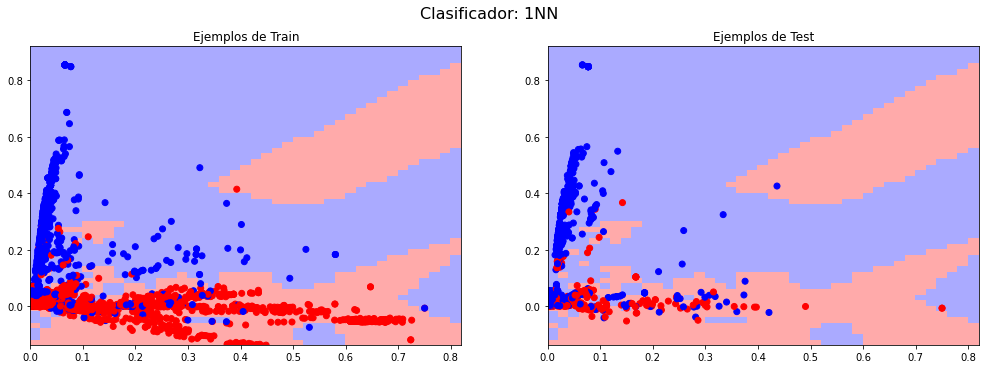

In [61]:
datos['Clean Text'] = datos['text'].apply(clean_txt)
datos_Inst = datos_lemm.copy()

np.random.seed(12)
longitud = datos_Inst.shape[0]//4
division = int(longitud*0.8)
datos_Inst = datos_Inst[:longitud]

X_train = datos_Inst.iloc[:division,0]
X_test = datos_Inst.iloc[division:,0]
y_train = datos_Inst.iloc[:division,1]
y_test = datos_Inst.iloc[division:,1]

print(X_train.shape, X_test.shape)

vectorizer = CountVectorizer(stop_words = "english")
X_train_counts = vectorizer.fit_transform(X_train)
palabrasAprendidas = vectorizer.get_feature_names()
X_test_counts = vectorizer.transform(X_test)
tdidf = TfidfTransformer()

X_train_tfidf = tdidf.fit_transform(X_train_counts)
X_test_tfidf = tdidf.transform(X_test_counts)

lsa = TruncatedSVD(n_components=2)
lsa.fit(X_train_tfidf)
X_train = lsa.transform(X_train_tfidf)
X_test = lsa.transform(X_test_tfidf)

# Creamos el clasificador knn con neighbors.KNeighborsClassifier y n_neighbors=1
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn = knn.fit(X_train, y_train)
salidasTrain = leaveOneOut(knn, X_train, y_train)
predictionTest = knn.predict(X_test)
accTrain = metrics.accuracy_score(salidasTrain,y_train)
accTest = metrics.accuracy_score(predictionTest, y_test)
print("Resultados sin pre-procesar con 1NN")
print("Precisión en train: {}".format(accTrain))
print("Precisión en test: {}".format(accTest))
    
mostrar(knn, X_train, y_train, X_test, y_test)

In [56]:
def ENN(X, y, k=3):
    """
    Algoritmo ENN para la selección de instancias. Cada ejemplo se elimina si se clasifica incorrectamente por sus k vecinos más cercanos
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    # inicialmente todos los índices/instancias son seleccionadas
    S = (np.ones_like(y) == 1)

    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    # Para cada ejemplo, comprobamos si este es fallado al ser clasificado por sus k vecinos más cercanos (sin contar a sí mismo)
    for i in range(0, X.shape[0]):
        # Eliminamos el ejemplo de la selección para no tenerlo en cuenta al clasificarlo: modificar la máscara
        S[i] = False
        # Entrenamos knn con el conjunto de instancias seleccionadas actualmente
        knn.fit(X[S,:], y[S])
        # Si la instancia es correctamente clasificada restauramos su valor en la máscara
        if (knn.predict(X[i,:].reshape(1,-1)) == y[i]):
            S[i] = True
    return S

In [57]:
def ejecutaMetodoIS(funcionMetodo, clasificador, X_train, y_train, X_test, y_test, verbose=True):
    """
    Esta función se encajar de ejecutar un método de selección de instancias y dar los resultados sobre train y test
    con el clasificador introducido como parámetro
    :param funcionMetodo: Función con el método de selección de instancias a ejecutar
    :param clasificador: Instancia del clasificador a utilizar para obtener la precisión en train y test
    :param train: Conjunto de datos de entrenamiento leído del formato keel con campos data y target
    :param test: Conjunto de datos de test leído del formato keel con campos data y target
    :return: tupla con la máscara de ejemplos seleccionados, la precisión en train, precisión en test y porcentaje de reducción obtenido
    """
    # Obtenemos el nombre del método. Como es una función utilizamos su campo __name__
    nombreMetodo = funcionMetodo.__name__
    if verbose:
        print ("Ejecutando " + nombreMetodo + "...")
    # Ejecutamos el método de selección de instancias correspondiente con los ejemplos de entrenamiento y sus clases
        # Utilizad todos los métodos con los parámetros por defecto y almacenad la máscara devuelta en una variable llamada S
    S = funcionMetodo(X_train, y_train)
    
    # Entrenamos el clasificador correspondiente solo con los ejemplos seleccionados (aplicamos la máscara S)
    clasificador.fit(X_train[S,:], y_train[S])
    
#     # Obtenemos las salidas para train mediante leaveOneOut
    predictionTrain = leaveOneOut(clasificador, X_train, y_train)
#     # Obtenemos la precisión en train con las salidas obtenidas (tanto por uno)
    accTrain = metrics.accuracy_score(predictionTrain, y_train)
#     # Obtenemos las salidas para test 
    predictionTest = clasificador.predict(X_test)
#     # Obtenemos la precisión en test  (tanto por uno)
    accTest = metrics.accuracy_score(predictionTest, y_test)
    # Calculamos el porcentaje de reducción
    reduction = ((S.size-sum(S))/S.size) * 100
        
    if verbose:
        print("Resultados " + nombreMetodo + " python")
        print("Precisión en train: {}".format(accTrain))
        print("Precisión en test: {}".format(accTest))
        print("Reducción " + nombreMetodo + ": {} de {}".format(S.sum(), S.size))
        print("Reducción: %2.2f%%" % reduction)
        # En caso de ser un árbol, imprimimos el número de reglas obtenidas
        if type(clasificador) == tree.DecisionTreeClassifier:
            print("Número de reglas: {}".format(clasificador.tree_.node_count))

    # Mostramos los resultados obtenidos por el método gráficamente
    mostrar(clasificador, X_train, y_train, X_test, y_test,  nombreMetodo, X_train[S,:], y_train[S])
    
    # Si es un árbol, devolvemos el número de reglas obtenidas
    nReglas = -1
    if type(clasificador) == tree.DecisionTreeClassifier:
        nReglas = clasificador.tree_.node_count
    return S, accTrain, accTest, reduction, nReglas

Ejecutando ENN...
Resultados ENN python
Precisión en train: 0.8597432458325349
Precisión en test: 0.7593869731800766
Reducción ENN: 4429 de 5219
Reducción: 15.14%


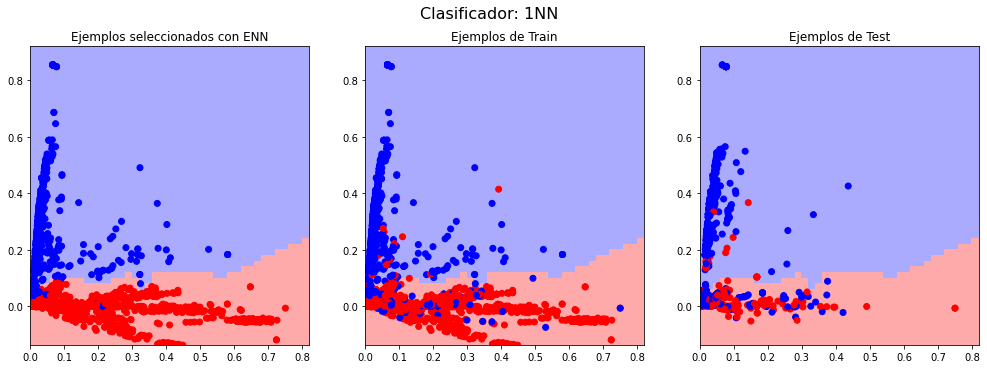

In [62]:
_, accTrain, accTest, reduction, _ = ejecutaMetodoIS(ENN, knn, X_train, y_train, X_test, y_test)

In [50]:
def CNN(X, y, k=1):
    """
    Algoritmo CNN para la selección de instancias. Se comienza con dos ejemplos aleatorios (uno de cada clase) y cada ejemplo
    que se falla al ser clasificado por los ya seleccionados se añade a la selección (se para cuando ya no se añaden más ejemplos)
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RNN establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)

    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    S = (np.zeros_like(y) == 1)

    # Inicialmente, seleccionamos aleatoriamente una instancia de cada clase
    # Anotamos el número de clases
    nClases = np.unique(y)
    # Para cada clase, buscamos los índices de los ejemplos de dicha clase y seleccionamos uno de ellos aleatoriamente
    # Dicho ejemplo coge el valor True en S
    for c in nClases:
        indicesClase = np.where(y == c)[0]  # np.where devuelve una tupla, nos interesa la primera parte que contiene los índices de las posiciones que no son 0 o False
        # Elegid una instancia aleatoriamente de las de la clase: utilizad randint de Numpy para ello
        instanciaAleatoria = np.random.randint(0,len(indicesClase))

        # Modificad la máscara S de acuerdo a la instancia seleccionada
        S[indicesClase[instanciaAleatoria]] = True

    # Solo evaluamos los ejemplos que no están en S (los que están se aciertan por definición al considerlos
    # como vecinos de sí mismos). Estos ejemplos son los únicos que podemos añadir a S
    notS = np.logical_not(S)

    # "Entrenamos" knn con los ejemplos seleccionados
    knn = knn.fit(X[S],y[S])
    # Inicializamos el número de fallados para entrar en el bucle. El algoritmo termina cuando no se fallan ejemplos
    fallados = -1
    while fallados != 0:
        # Ponemos el contador de fallados a 0 y comprobamos todos los ejemplos no seleccionados
        fallados = 0
        # Obtenemos los índices de los ejemplos no seleccionados: utilizad np.where como se ha hecho anteriormente
        indices = np.where(notS == True)[0]
        # Para cada ejemplo no seleccionado (y en orden aleatorio) comprobamos si dicho ejemplo se falla         
        # con las instancias en S actualmente. Si se falla, el ejemplo se añade a S, se reentrena KNN y se suma uno a fallados
        for i in np.random.permutation(indices):
            if(knn.predict(X[i,:].reshape(1,-1)) != y[i]):
                S[i] = True
                knn = knn.fit(X[S],y[S])
                fallados += 1
        # Recalculamos los ejemplos a estudiar en la próxima iteración, aquellos no seleccionados
        notS = np.logical_not(S)
        print("CNN, fin de iteración, fallados: {}, ejemplos en S: {}".format(fallados, np.sum(S)))

    return S

Ejecutando CNN...
CNN, fin de iteración, fallados: 1329, ejemplos en S: 1331
CNN, fin de iteración, fallados: 388, ejemplos en S: 1719
CNN, fin de iteración, fallados: 48, ejemplos en S: 1767
CNN, fin de iteración, fallados: 4, ejemplos en S: 1771
CNN, fin de iteración, fallados: 0, ejemplos en S: 1771
Resultados CNN python
Precisión en train: 0.7202529220157118
Precisión en test: 0.7180076628352491
Reducción CNN: 1771 de 5219
Reducción: 66.07%


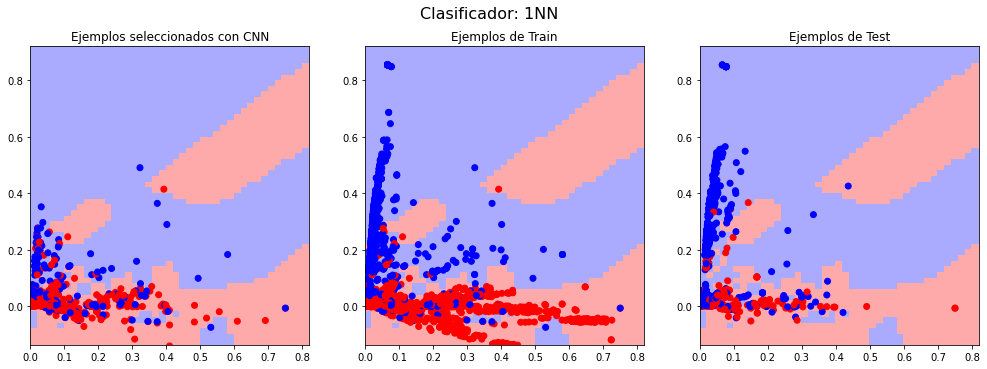

In [63]:
    _, accTrain, accTest, reduction, _ = ejecutaMetodoIS(CNN, knn, X_train, y_train, X_test, y_test)

In [52]:
def RMHC(X, y, s=0.1, iteraciones=1000, k=1):
    """
     Algoritmo RMHC (Random Mutation Hill Climbing) para la selección de instancias.
      Se comienza con una selección aleatoria de s * nEjemplos instancias. Para cada iteración, se elige una instancia
      seleccionada y una no seleccionada para ser intercambiadas. Si el intercambio mejora la precisión (leave-one-out) sobre train
      se mantiene el cambio, sino se deshace
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param s: Porcentaje de instancias a ser seleccionadas (s es un valor entre 0 y 1)
    :param iteraciones: Número de iteraciones (intercambios) a probar
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RMHC establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)

    # En este caso vamos a mantener dos vectores de enteros con los índices de las instancias seleccionadas y no seleccionadas
    # Establecemos el número de instancias a seleccionar (es fijo)
    nSel = int(s * X.shape[0])
    # Obtenemos una permutación aleatoria de todos los índices disponibles 
    # (un array de 0 a X.shape[0] con valores ordenados aleatoriamente): utilizad permutation de Numpy
    permute = np.random.permutation(X.shape[0])
    # Cogemos como seleccionadas las instancias correspondientes a los primeros nSel índices  y no seleccionadas el resto
    seleccionadas = permute[:nSel]
    noSeleccionadas = permute[nSel:]

    # Calculamos la preicisión con la selección inicial
    # Entrenamos KNN con las instancias seleccionadas
    knn = knn.fit(X[seleccionadas,:], y[seleccionadas])
    # Obtenemos las salidas con leaveOneOut (para no tener en cuenta las instancias seleccionadas como vecinos de sí mismas)
    salidas = leaveOneOut(knn, X, y)
    # Calculamos la precisión
    acc = metrics.accuracy_score(salidas, y)

    # Comenzamos las iteraciones:
    #   En cada una, intercambiamos una instancia seleccionada con una que no lo está y comprobamos si mejora la precisión
    for i in range(0, iteraciones):
        # Seleccionamos un índice de manera aleatoria que nos indica la instancia a eliminar de las seleccionadas: randint de Numpy
        quitar = np.random.randint(0,len(seleccionadas))
        # Seleccionamos un índice de manera aleatoria que nos indica la instancia a añadir a las seleccionadas: randint de Numpy
        poner = np.random.randint(0,len(noSeleccionadas))
        # Guardamos el ejemplo eliminado
        aux = seleccionadas[quitar]
        # Añadimos la nueva instancia seleccionada sustituyendo la que se elimina: intercambio en las listas de seleccionados y no seleccionados
        seleccionadas[quitar] = noSeleccionadas[poner]
        # Entrenamos de nuevo kNN
        knn = knn.fit(X[seleccionadas], y[seleccionadas])

        # Calculamos la precisión de la solución actual
        # Obtenemos las salidas con leaveOneOut (para no tener en cuenta las instancias seleccionadas como vecinos de sí mismas)
        salidas = leaveOneOut(knn, X, y)
        # Calculamos la precisión
        accNew = metrics.accuracy_score(salidas, y)

        # Si la precisión actual es peor que la anterior, devolvemos la instancia eliminada a las seleccionadas
        # Sino si la precisión de la solución actual es mejor o igual que la anterior, guardamos la precisión y
        #  añadimos la instancia eliminada a las no seleccionadas
        if (accNew < acc):
            seleccionadas[quitar] = aux
        else:
            acc = accNew
            noSeleccionadas[poner] = aux

        if i % 100 == 0:
            print("precision en iteracion {}: {}".format(i, acc))

    # A partir de las seleccionadas creamos la máscara de instancias seleccionadas 
    # donde True en la posición i indica que la instancia i es seleccionada
    S = (np.zeros_like(y) == 1)
    S[seleccionadas] = True

    return S

Ejecutando RMHC...
precision en iteracion 0: 0.7848246790572907
precision en iteracion 100: 0.8011113240084308
precision en iteracion 200: 0.8116497413297566
precision en iteracion 300: 0.8198888675991569
precision en iteracion 400: 0.8256370952289711
precision en iteracion 500: 0.8315769304464457
precision en iteracion 600: 0.8378999808392412
precision en iteracion 700: 0.8407740946541483
precision en iteracion 800: 0.8440314236443763
precision en iteracion 900: 0.8469055374592834
Resultados RMHC python
Precisión en train: 0.8515041195631347
Precisión en test: 0.7478927203065134
Reducción RMHC: 521 de 5219
Reducción: 90.02%


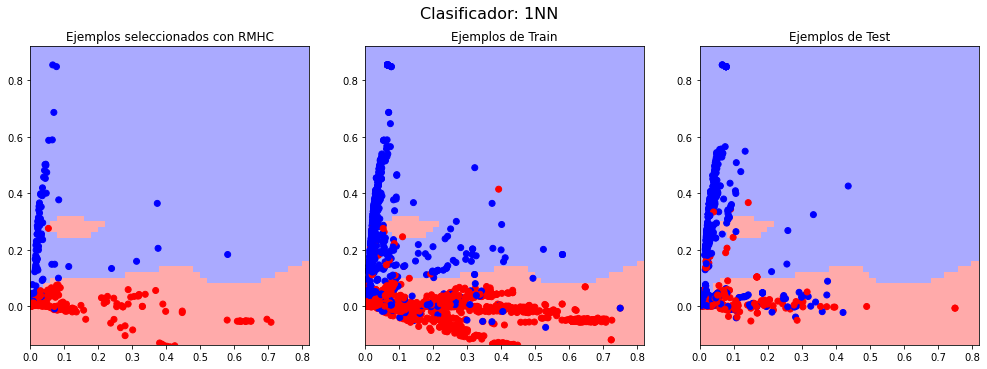

In [64]:
_, accTrain, accTest, reduction, _ = ejecutaMetodoIS(RMHC, knn, X_train, y_train, X_test, y_test)